In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import allocate, Overlay

In [2]:
resize_design = Overlay("resizer.bit")

/usr/local/share/pynq-venv/lib/python3.8/site-packages/pynq/ps.py:462: UserWarning: Setting frequency to the closest possible value 98.8879MHz.
  warnings.warn(


In [3]:
dma = resize_design.axi_dma_0
resizer = resize_design.resize_accel_0

In [4]:
image_path = "pynq.jpeg"
original_image = Image.open(image_path)

Image size: 3840x2160 pixels.


<Figure size 864x576 with 0 Axes>

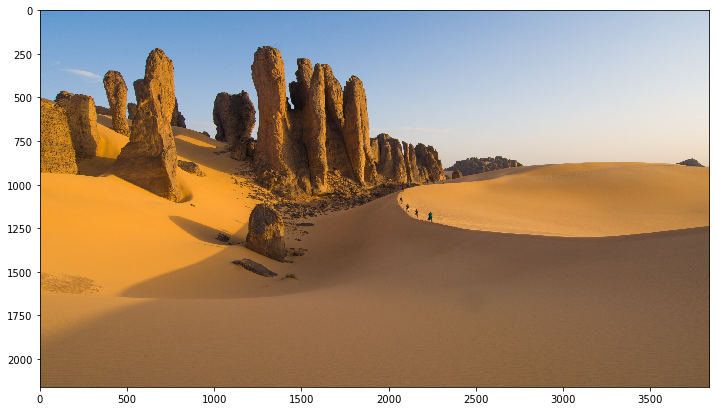

In [5]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)

old_width, old_height = original_image.size
print("Image size: {}x{} pixels.".format(old_width, old_height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(original_image)

In [6]:
resize_factor = 4
new_width = int(old_width/resize_factor)
new_height = int(old_height/resize_factor)

In [7]:
in_buffer = allocate(shape=(old_height, old_width, 3), 
                           dtype=np.uint8, cacheable=1)
out_buffer = allocate(shape=(new_height, new_width, 3), 
                            dtype=np.uint8, cacheable=1)

In [8]:
in_buffer[:] = np.array(original_image)

In [9]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    resizer.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [10]:
resizer.register_map.src_rows = old_height
resizer.register_map.src_cols = old_width
resizer.register_map.dst_rows = new_height
resizer.register_map.dst_cols = new_width

In [11]:
run_kernel()
resized_image = Image.fromarray(out_buffer)

Image size: 960x540 pixels.


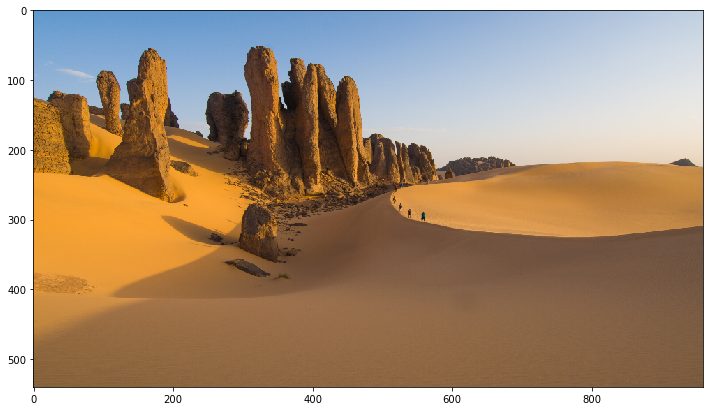

In [12]:
print("Image size: {}x{} pixels.".format(new_width, new_height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(resized_image)

In [13]:
%%timeit
run_kernel()
resized_image = Image.fromarray(out_buffer)

88.2 ms ± 37.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
del in_buffer
del out_buffer